# Acute Organ Failure Intervention Model

To execute,

1. Install Apache Spark from https://spark.apache.org/downloads.html
2. Download MIMIC-3 demo dataset from https://physionet.org/content/mimiciii-demo/1.4/
3. Extract csv files under ./mimic-iii-clinical-database-demo-1.4
4. Run parquetizer.py with the following command:

`spark-submit parquetizer.py`

5. Run model trainer mimic_hp_training_scale.py with the following command:

`spark-submit mimic_hp_training_scale.py`


# Using mimic_post_hoc_analysis class for further analyses


In [1]:

from mimic_post_hoc_analysis import mimic_post_hoc_analysis
cur_evaluator = mimic_post_hoc_analysis(is_debug=False, cur_signature="MIMIC3_DEMO"
                                            , target_disease=["42731"],hyperparam_selection="TVT")
import logging
cur_evaluator.logger.setLevel(logging.WARN)

cur_evaluator.set_top_intv_k(cur_top_k=5)


[2019-11-06 17:47:10,064data_abstracter.py:56 -             __init__() ] HOME_DIR:./output/MIMIC3_DEMO/
[2019-11-06 17:47:10,066data_abstracter.py:57 -             __init__() ] DATA_DIR:./mimic3_demo_dataset/
[2019-11-06 17:47:10,067data_abstracter.py:58 -             __init__() ] INTERMEDIATE_DIR:./output/MIMIC3_DEMO//temp/
[2019-11-06 17:47:24,631mimic_hp_training_scale.py:45 -             __init__() ] preprocessor_init done
[2019-11-06 17:47:24,632mimic_hp_training_scale.py:55 -             __init__() ] run_experiment done
[2019-11-06 17:47:25,398mimic_hp_training_scale.py:58 -             __init__() ] PREPROCESSOR_OUT


# Lab tests showed positive correlation with instance-level predictions
### Tests were measured during the prediction time window


In [2]:

from IPython.display import display, HTML
cur_pandas = cur_evaluator.corr_predicted_risks()
for target_df in cur_pandas:
    display(HTML(target_df.to_html()))


,ITEMID,Pearson_Correlation,Num_OBS,LABEL,SOURCE
0,50910,0.924712,5,Creatine Kinase (CK),LAB
1,50911,0.900046,6,"Creatine Kinase, MB Isoenzyme",LAB
2,50868,0.688535,31,Anion Gap,LAB
3,50863,0.656966,4,Alkaline Phosphatase,LAB
4,50818,0.641187,22,pCO2,LAB
5,50804,0.592602,22,Calculated Total CO2,LAB
6,50970,0.538423,32,Phosphate,LAB
7,50912,0.418523,31,Creatinine,LAB
8,50802,0.414258,22,Base Excess,LAB
9,50885,0.386482,4,"Bilirubin, Total",LAB


# Lab tests showed negative correlation with instance-level predictions
### Tests were measured during the prediction time window


In [3]:
cur_pandas = cur_evaluator.corr_predicted_risks(ascending=True)
for target_df in cur_pandas:
    display(HTML(target_df.to_html()))



,ITEMID,Pearson_Correlation,Num_OBS,LABEL,SOURCE
0,50867,-1.000000,2,Amylase,LAB
1,50817,-0.812277,4,Oxygen Saturation,LAB
2,50813,-0.765521,8,Lactate,LAB
3,50882,-0.589331,31,Bicarbonate,LAB
4,50983,-0.582930,32,Sodium,LAB
5,50821,-0.516630,22,pO2,LAB
6,50820,-0.485831,22,pH,LAB
7,51277,-0.483770,25,RDW,LAB
8,50878,-0.461652,4,Asparate Aminotransferase (AST),LAB
9,50861,-0.460276,4,Alanine Aminotransferase (ALT),LAB


# Patient-level probability density on the training set


Text(0.5,1,"Pts dx'ed w/o ['42731']")

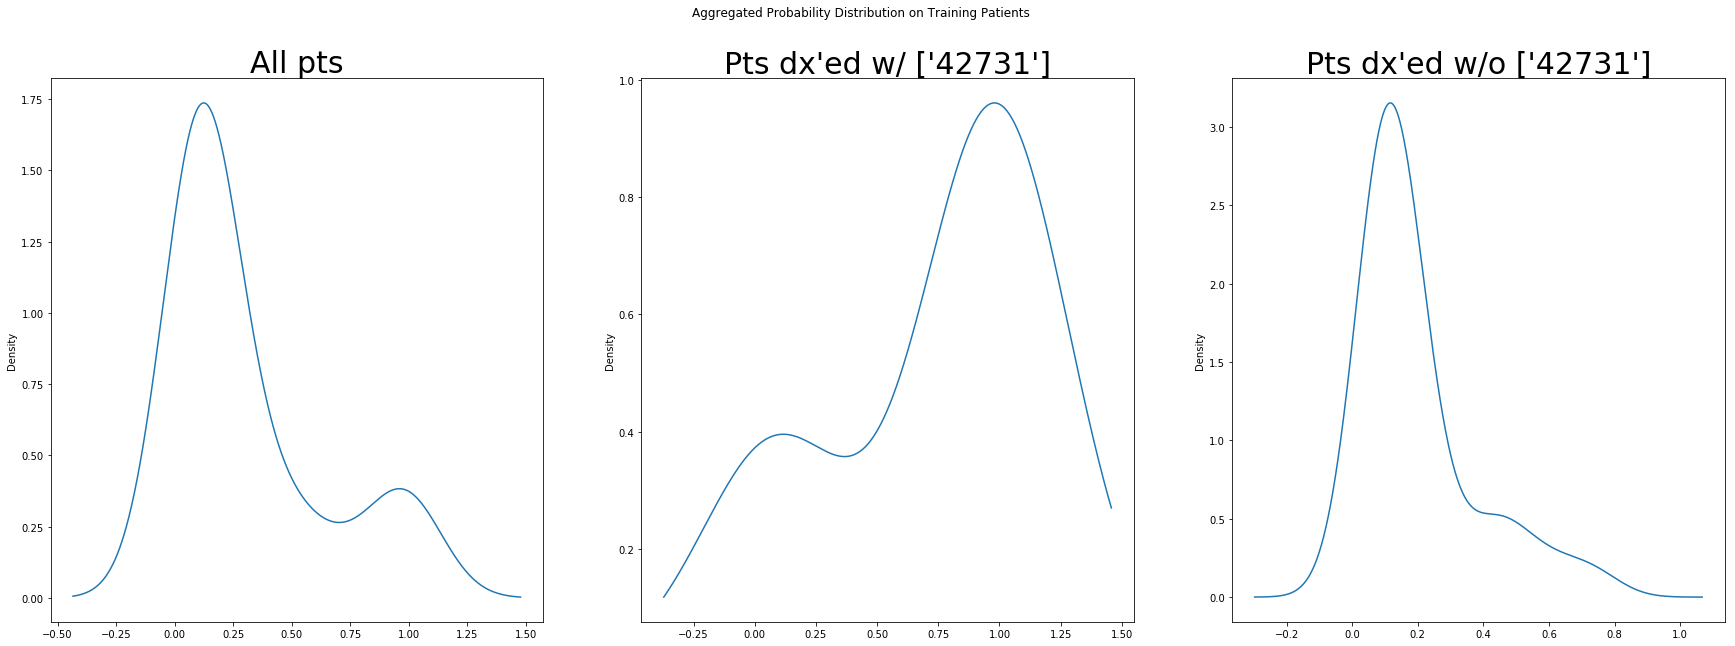

In [9]:
training_agg_prob, testing_agg_prob = cur_evaluator.evaluate_agg_prob()

import matplotlib.pyplot as plt 

%matplotlib inline

fig1 = plt.figure(figsize=(30,10))

ax11 = fig1.add_subplot(131)
ax12 = fig1.add_subplot(132)
ax13 = fig1.add_subplot(133)

from pyspark.sql.functions import col

training_agg_prob.select("agg_prob").toPandas().plot.kde(ax=ax11,legend=False)
training_agg_prob.where(col(cur_evaluator.target_disch_col) == 1)\
    .select("agg_prob").toPandas().plot.kde(ax=ax12,legend=False)
training_agg_prob.where(col(cur_evaluator.target_disch_col) == 0)\
    .select("agg_prob").toPandas().plot.kde(ax=ax13,legend=False)

fontdict={'fontsize': 30, 'fontweight': 'medium'}

fig1.suptitle("Aggregated Probability Distribution on Training Patients",fontdict = fontdict)
ax11.set_title("All pts".format(cur_evaluator.target_disch_icd9),fontdict = fontdict)
ax12.set_title("Pts dx'ed w/ {0}".format(cur_evaluator.target_disch_icd9),fontdict = fontdict)
ax13.set_title("Pts dx'ed w/o {0}".format(cur_evaluator.target_disch_icd9),fontdict = fontdict)



# Patient-level probability density on the test set

TESTING PTS w/ Disease is less than two


Text(0.5,1,"Pts dx'ed w/o ['42731']")

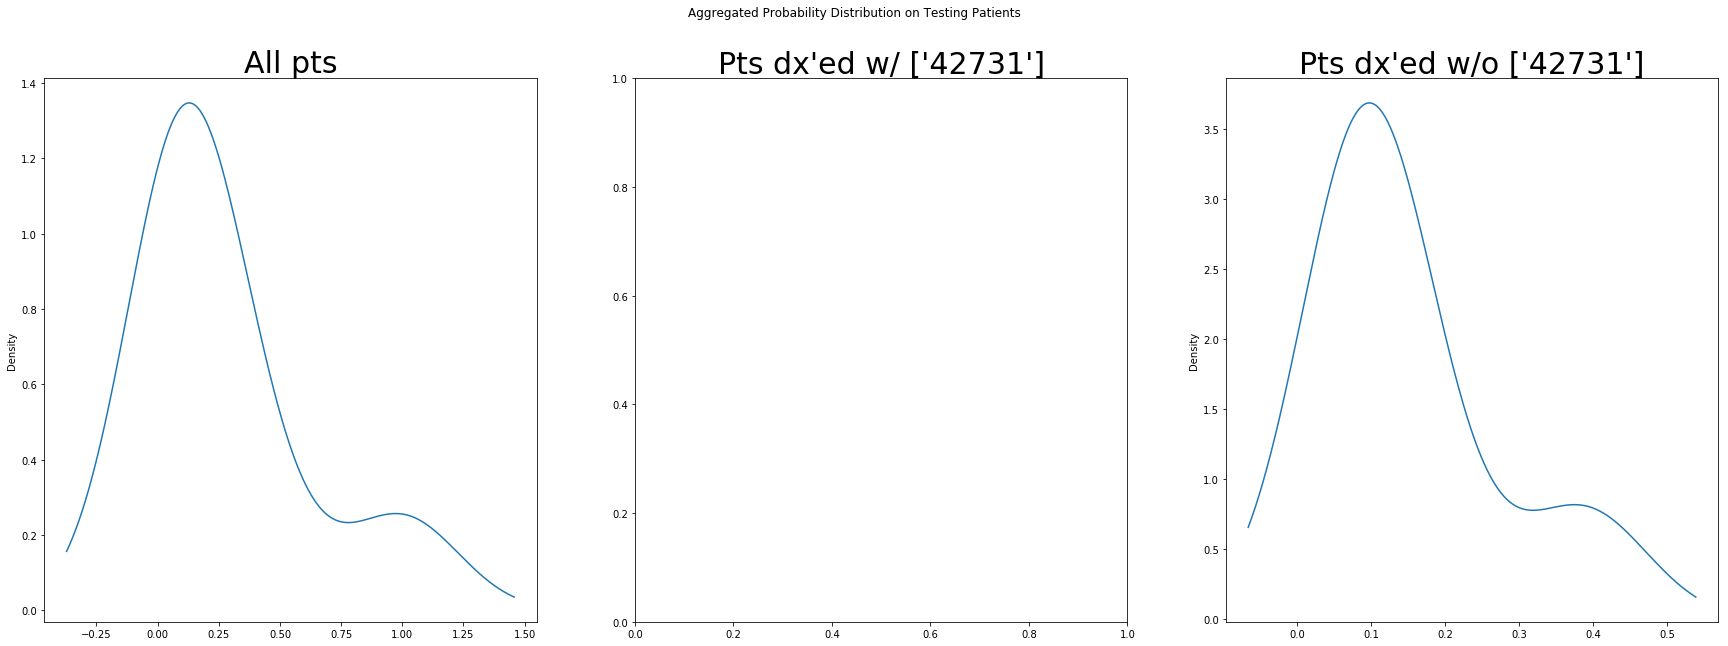

In [8]:

fig2 = plt.figure(figsize=(30,10))


from pyspark.sql.functions import col

ax21 = fig2.add_subplot(131)
testing_agg_prob.select("agg_prob").toPandas().plot.kde(ax=ax21,legend=False)

ax22 = fig2.add_subplot(132)
if testing_agg_prob.where(col(cur_evaluator.target_disch_col) == 1).count() > 1:
    testing_agg_prob.where(col(cur_evaluator.target_disch_col) == 1)\
        .select("agg_prob").toPandas().plot.kde(ax=ax22,legend=False)
else:
    print("TESTING PTS w/ Disease is less than two")

ax23 = fig2.add_subplot(133)
if testing_agg_prob.where(col(cur_evaluator.target_disch_col) == 0).count() > 1:
    testing_agg_prob.where(col(cur_evaluator.target_disch_col) == 0)\
        .select("agg_prob").toPandas().plot.kde(ax=ax23,legend=False)
else:
    print("TESTING PTS w/o Disease is less than one")

fontdict={'fontsize': 30, 'fontweight': 'medium'}

fig2.suptitle("Aggregated Probability Distribution on Testing Patients",fontdict=fontdict)
ax21.set_title("All pts".format(cur_evaluator.target_disch_icd9),fontdict=fontdict)
ax22.set_title("Pts dx'ed w/ {0}".format(cur_evaluator.target_disch_icd9),fontdict=fontdict)
ax23.set_title("Pts dx'ed w/o {0}".format(cur_evaluator.target_disch_icd9),fontdict=fontdict)


# Feature contribution from the selected model


In [6]:

#3. Feature contribution from the model
from pyspark.ml import PipelineModel

from glob import glob
import os
potential_model_list = cur_evaluator.model_dir_template.format(cur_evaluator.target_disch_col,"*")
list_potential_models = glob(potential_model_list)
print("List of identified models:{0}".format(list_potential_models))
print("Using {0}".format(list_potential_models[0]))

cur_model = PipelineModel.load(list_potential_models[0]).stages[-1]

cur_feature_contribution = cur_evaluator.eval_feature_contribution(cur_model,top_k=10)
display(HTML(cur_feature_contribution.to_html()))


List of identified models:['./output/MIMIC3_DEMO\\MIMIC3_DEMO_DISCH_42731_GB_TVT_0.7_p_val_top_5_INTV_TOP_AUPRC_5_0.125']
Using ./output/MIMIC3_DEMO\MIMIC3_DEMO_DISCH_42731_GB_TVT_0.7_p_val_top_5_INTV_TOP_AUPRC_5_0.125


C:\Users\mudjj\Anaconda3\lib\site-packages\pyspark\sql\session.py:340: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


,IG,ITEMID,LABEL,feature_type,method_or_value
0,0.314744,223792,Pain Management,categorical,PCA
1,0.176246,223751,Non-Invasive Blood Pressure Alarm - High,numeric,LT
2,0.154205,220048,Heart Rhythm,categorical,AF (Atrial Fibrillation)
3,0.066793,N/A,MARITAL_STATUS,demographics,DIVORCED
4,0.044728,223751,Non-Invasive Blood Pressure Alarm - High,numeric,TT
5,0.044625,220181,Non Invasive Blood Pressure mean,numeric,avg
6,0.027869,224847,Impaired Skin Drainage Amount #1,categorical,Small
7,0.021487,224756,Response,categorical,No Response
8,0.017592,223991,Cough Effort,categorical,None
9,0.014462,225187,Back Care,categorical,1


# Selected interventions for annotation


In [7]:
intervention_used_to_annotate = cur_evaluator.spark.read.parquet(cur_evaluator
                                 .annot_intv_dir.format(cur_evaluator.target_disch_col,cur_evaluator.sel_top))

target_intervention = cur_evaluator.get_def_df().join(intervention_used_to_annotate,"ITEMID")\
    .select("LABEL","SOURCE","p_val").orderBy("p_val").toPandas()

display(HTML(target_intervention.to_html()))


,LABEL,SOURCE,p_val
0,Labetalol,MED,0.188041
1,Amiodarone,MED,0.264210
2,Diltiazem,MED,0.264210
3,Ranitidine (Prophylaxis),MED,0.264210
4,Fluoroscopy,PROC,0.264210
